In [1]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from math import sqrt

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import seaborn as sns

sns.set_theme(style="whitegrid")

# Functions

In [2]:
def plot_var(wdf, odf, wvar, ovar, daterange, site):
    wdf = wdf[daterange[0] : daterange[1]]
    odf = odf[daterange[0] : daterange[1]]
    
    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(20,6))
    
    ax.plot(wdf.index, wdf[wvar], color='blue', label=f'WRF {wvar}')
    ax.plot(odf.index, odf[ovar], color='orange', label=f'Obs {wvar}')

    fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

    ax.set(title=f'Model vs. Observational {wvar}\n {site} {month}/{year}',
           ylabel=f'{ovar}')

    plt.show()
    
def plot_scatter(wdf, odf, wvar, ovar, site):
    join_df = wdf[[wvar]].join(odf[[ovar]],  how='inner')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=join_df[ovar],
               y=join_df[wvar],
               alpha=0.25)
    
    ax.set(xlabel='Observed',
           ylabel='WRF',
           title=f'{site} {ovar}')
           
    plt.show()
    
def plot_scatter(wdf, odf, wvar, ovar, site):
    join_df = wdf[[wvar]].join(odf[[ovar]],  how='inner')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=join_df[ovar],
               y=join_df[wvar],
               alpha=0.25)
    
    ax.set(xlabel='Observed',
           ylabel='WRF',
           title=f'{site} {ovar}')
           
    plt.show()
    
def plot_cdf(wdf, odf, wvar, ovar, site):
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.ecdfplot(data=wdf, x=wvar, ax=ax, color='blue', label='WRF')
    sns.ecdfplot(data=odf, x=ovar, ax=ax, color='orange', label='Observed')
    
    plt.legend(loc='upper left')
    ax.set(title=f'{site} CDF\n{ovar}')
    
def plot_kde(wdf, odf, wvar, ovar, site):
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.kdeplot(data=wdf, x=wvar, ax=ax, color='blue', label='WRF')
    sns.kdeplot(data=odf, x=ovar, ax=ax, color='orange', label='Observed')
    
    plt.legend(loc='upper left')
    ax.set(title=f'{site} PDF\n{ovar}')

    
#### Calculate wind speed/direction from components ####
def get_wind(df): 
    u = df['U10'].values * units('m/s')
    v = df['V10'].values * units('m/s')

    df['WND_SPD'] = wind_speed(u,v)
    df['WND_DIR'] = wind_direction(u, v, convention='from')
    
    return df





## Read in data

In [3]:
def prep_wrf_data(fpath, var_name_dict, site):
    df = pd.read_pickle(fpath)
    df['T2'] = df['T2'] - 273  # Convert C to K
    df.index = df.index - pd.Timedelta(hours = 8)  # UTC to PST
    df = get_wind(df)  # Calc wind direction/speed
    df.rename(columns=var_name_dict, inplace=True)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'wrf'
    
    return df

def prep_obs_data(fpath, site):
    df = pd.read_csv(fpath, index_col='time (PST)')
    df.index = pd.to_datetime(df.index)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'obs'
    
    return df

## Run calculations

In [4]:
def run_stats(df, var, site):
    # Subset to site and var
    df = df.loc[df['site'] == site]

    # Define validation/model data
    xval = df.loc[df['source']=='obs'][var].rename('val')
    ymod = df.loc[df['source']=='wrf'][var].rename('model')
    
    # Inner join
    df = pd.concat([xval, ymod], axis=1, join='inner')
    df.dropna(inplace=True)
    xval = df['val']
    ymod = df['model']
    
    # Calculate stats
    res = np.corrcoef(xval, ymod)
    corr = res[0,1]
    bias = (ymod - xval).mean()
    tmp = (ymod - xval)**2
    rmse = np.sqrt(tmp.mean())
    mabs = np.abs(ymod - xval).mean()
    # Return results
    results = { 
        'site' : [site],
        'variable' : [var],
        'correlation' : [round(corr, 2)],
        'bias' : [round(bias, 2)],
        'rmse' : [round(rmse, 2)],
        'mae' : [round(mabs, 2)]
    }
    
    df = pd.DataFrame(results)
    return df

def get_wind(df): 
    u = df['U10'].values * units('m/s')
    v = df['V10'].values * units('m/s')

    df['WND_SPD'] = wind_speed(u,v)
    df['WND_DIR'] = wind_direction(u, v, convention='from')
    
    return df

## Plotting functions

In [5]:
def plot_stats(df, metric):
    g = sns.catplot(
        data=stats_df, kind="bar",
        x="variable", y=metric, hue="site",
        palette="tab10", alpha=.6, height=8
    )
    g.set_axis_labels("", metric)

    g.legend.set_title("")
    g.set(title=metric)
    plt.show()

    
def plot_cdf(df, var_list, site):
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    df = df.loc[df['site'] == site]
    idx = 0
    
    # make plots
    for row in [0,1]:
        for col in [0,1]:
            sns.ecdfplot(data=df.loc[df['source']=='wrf'], x=var_list[idx], ax=ax[row,col], color='blue', label='WRF')
            sns.ecdfplot(data=df.loc[df['source']=='obs'], x=var_list[idx], ax=ax[row,col], color='orange', label='Observed')
            idx+=1
    
    # make legend
    for axes in ax.flat:
        legend = axes.get_legend()
        if legend is not None:
            legend.remove()

    fig.legend(['WRF', 'Observed'], loc='center left', bbox_to_anchor=(1.05, 0.5), title='Source')
    fig.tight_layout(rect=[0, 0, 1, .97])
    
    fig.suptitle(site)
    

    plt.show()
    
def plot_scatter(df, var_list, site):
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    df = df.loc[df['site'] == site]
    idx=0
      
    for row in [0,1]:
        for col in [0,1]:
            # Join to drop missing
            x=df.loc[df['source']=='obs'][var_list[idx]].rename('obs')
            y=df.loc[df['source']=='wrf'][var_list[idx]].rename('model')
            join_df = pd.concat([x,y], axis=1, join='inner')

            # Plot
            ax[row, col].scatter(x=join_df['obs'],
                                 y=join_df['model'],
                                 alpha=0.25)
            ax[row,col].axline((1, 1), slope=1, color='black', linestyle='--')

            ax[row,col].set(xlabel='Observed',
                            ylabel='WRF',
                            title=f'{site} {var_list[idx]}')
            ax[row, col].axis('equal')
            idx+=1
            
    fig.tight_layout(rect=[0, 0, .97, .97])
    fig.suptitle(site)
    
    plt.show()
    

def plot_timeseries(df, var, daterange, site):
    df = df.loc[df['site']==site]
    wdf = df.loc[df['source'] == 'wrf']
    odf = df.loc[df['source'] == 'obs']
    
    wdf = wdf[daterange[0] : daterange[1]]
    odf = odf[daterange[0] : daterange[1]]
    
    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(20,6))
    
    
    ax.plot(wdf.index, wdf[var], color='blue', label=f'WRF {var}')
    ax.plot(odf.index, odf[var], color='orange', label=f'Obs {var}')

    fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

    ax.set(title=f'Model vs. Observational {var}\n {site} {month}/{year}',
           ylabel=f'{var}')

    plt.show()
    

# Overall Agreement

## Read in and Prepare Data

In [6]:
var_name_dict = {
    'DFGDP' : 'fog drip',
    'T2' : 'air temperature (C)',
    'RH' : 'relative humidity (%)',
    'WND_SPD' : 'wind speed (m/s)',
    'WND_DIR' : 'wind direction (deg)'
}

#### WRF file paths ####
wdatadir = '/home/patmccornack/data/wrf_extracted/single_pixel'
wsauc_fname = 'wrf_sauc_2003-2010.pkl'
wupem_fname = 'wrf_upem_2003-2010.pkl'
wnrs_sci_fname = 'wrf_nrs_sci_2014-2019.pkl'

#### Obs file paths ####
odatadir = '/home/patmccornack/data/preprocessed'
osauc_fname = 'SAUC_hourly.csv'
oupem_fname = 'UPEM_hourly.csv'
onrs_sci_fname = 'NRS_SCI_hourly.csv'

#### Read in data ####
wsauc = prep_wrf_data(os.path.join(wdatadir, wsauc_fname), var_name_dict, site='Sauces Canyon')
wupem = prep_wrf_data(os.path.join(wdatadir, wupem_fname), var_name_dict, site='Upper Embudo Canyon')
wnrs_sci = prep_wrf_data(os.path.join(wdatadir, wnrs_sci_fname), var_name_dict, site='NRS SCI')

osauc = prep_obs_data(os.path.join(odatadir, osauc_fname), site='Sauces Canyon')
oupem = prep_obs_data(os.path.join(odatadir, oupem_fname), site='Upper Embudo Canyon')
onrs_sci = prep_obs_data(os.path.join(odatadir, onrs_sci_fname), site='NRS SCI')

In [7]:
# Join all into a single dataframe
df_list = [wsauc, wupem, wnrs_sci, osauc, oupem, onrs_sci]
for df in df_list:
    df['site'] = df.attrs['site']
    df['source'] = df.attrs['source']

df = pd.concat(df_list, join='inner', axis=0)
df.head(2)

,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),site,source
2002-06-30 16:00:00,16.731750,87.381705,3.002108,218.612980,Sauces Canyon,wrf
2002-06-30 17:00:00,18.919373,74.644099,0.134169,118.507522,Sauces Canyon,wrf


In [8]:
variables = ['air temperature (C)', 'relative humidity (%)', 'wind speed (m/s)', 'wind direction (deg)']
sites = ['Sauces Canyon', 'Upper Embudo Canyon', 'NRS SCI']

## Statistics

In [9]:
stats_df = pd.DataFrame()
for site in sites:
    for variable in variables:
        tmp = run_stats(df, variable, site)
        stats_df = pd.concat([stats_df, tmp], axis=0)
                     
stats_df['type'] = 'raw'
stats_df.to_csv('~/data/wrf_extracted/comparison_stats/wrf_raw_stats.csv')
stats_df

,site,variable,correlation,bias,rmse,mae,type
0,Sauces Canyon,air temperature (C),0.87,1.20,2.76,2.02,raw
0,Sauces Canyon,relative humidity (%),0.82,-8.21,17.54,12.76,raw
0,Sauces Canyon,wind speed (m/s),0.58,2.96,3.68,3.06,raw
0,Sauces Canyon,wind direction (deg),0.54,-8.39,93.55,55.16,raw
0,Upper Embudo Canyon,air temperature (C),0.89,1.61,3.10,2.28,raw
0,Upper Embudo Canyon,relative humidity (%),0.83,-12.21,20.39,14.99,raw
0,Upper Embudo Canyon,wind speed (m/s),0.64,3.35,3.97,3.37,raw
0,Upper Embudo Canyon,wind direction (deg),0.63,-2.07,84.09,52.77,raw
0,NRS SCI,air temperature (C),0.90,0.54,2.42,1.87,raw
0,NRS SCI,relative humidity (%),0.82,-3.07,16.05,11.44,raw


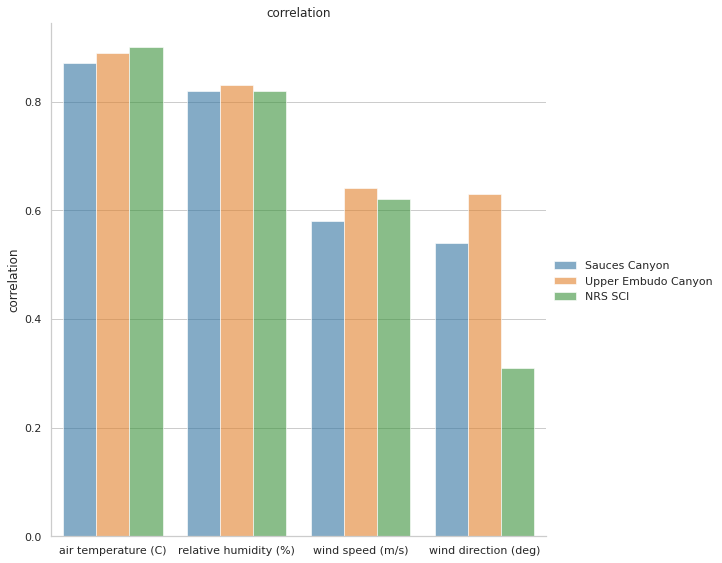

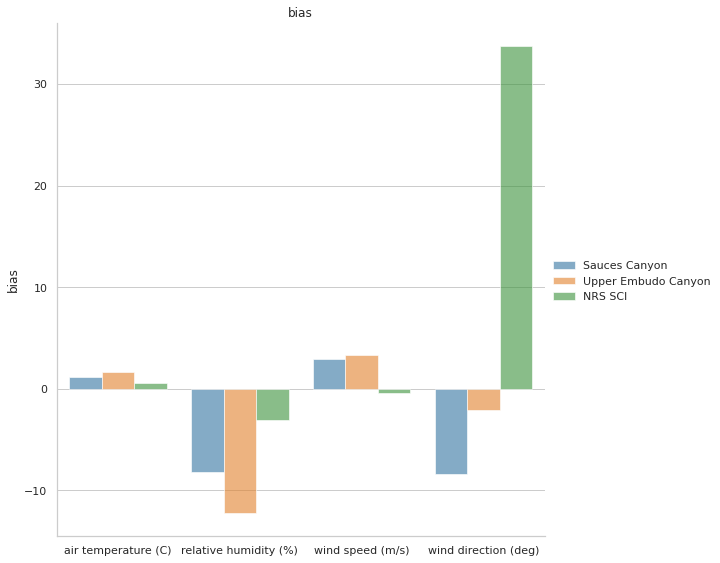

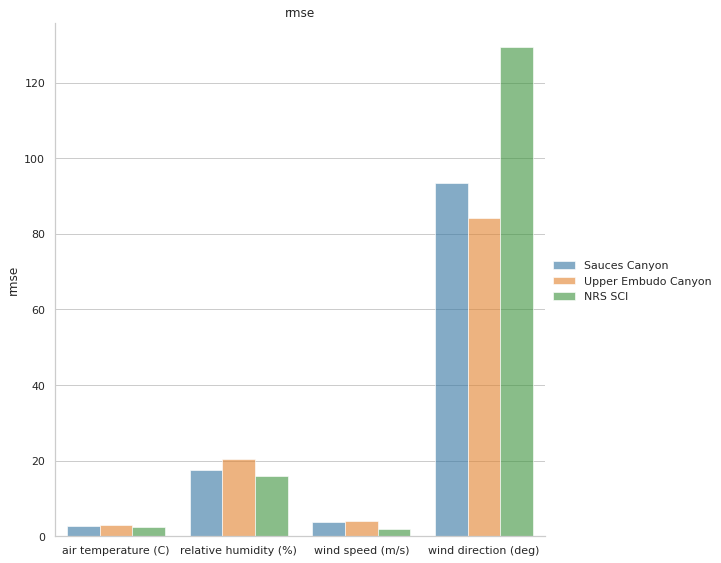

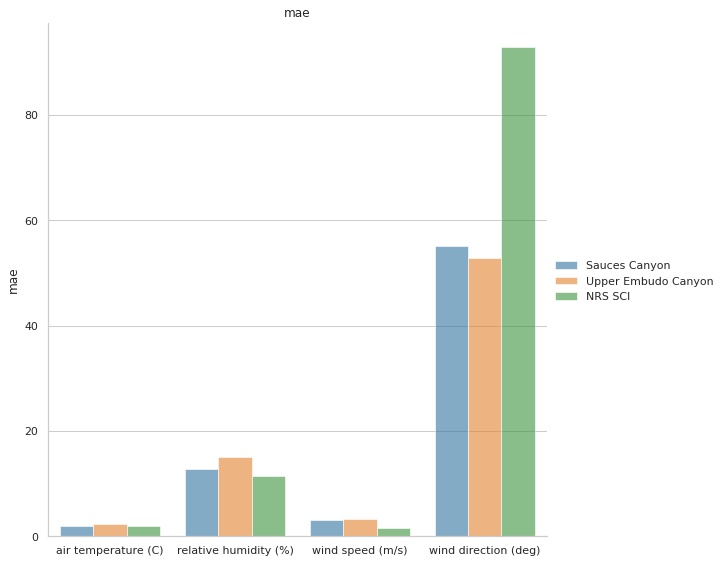

In [10]:
for metric in ['correlation', 'bias', 'rmse', 'mae']:
    plot_stats(df, metric)

## CDF Plots

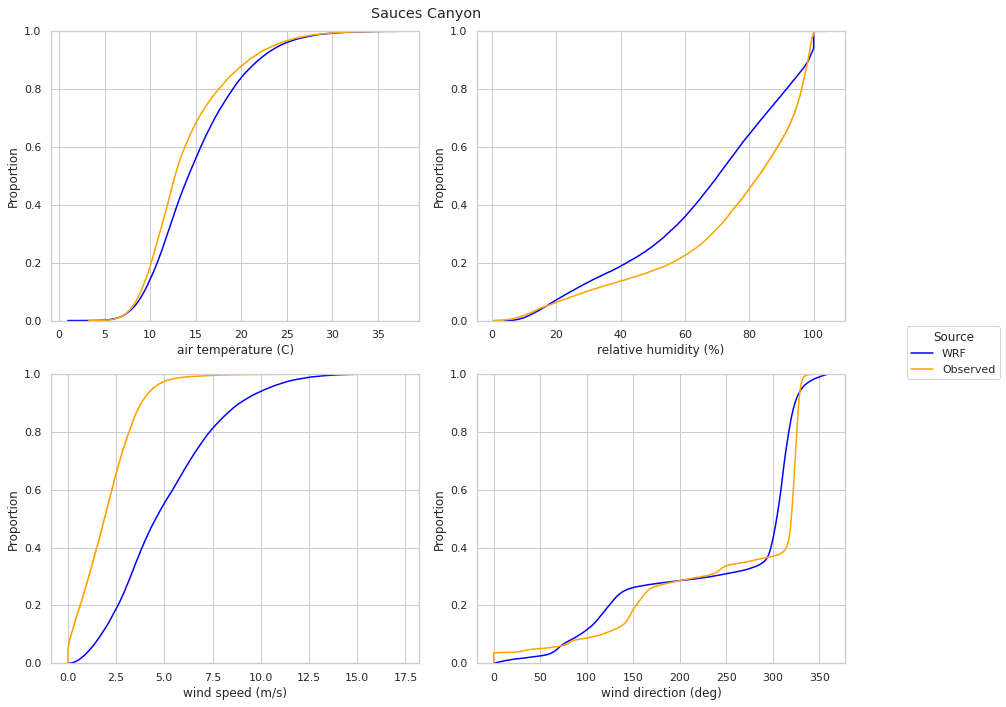

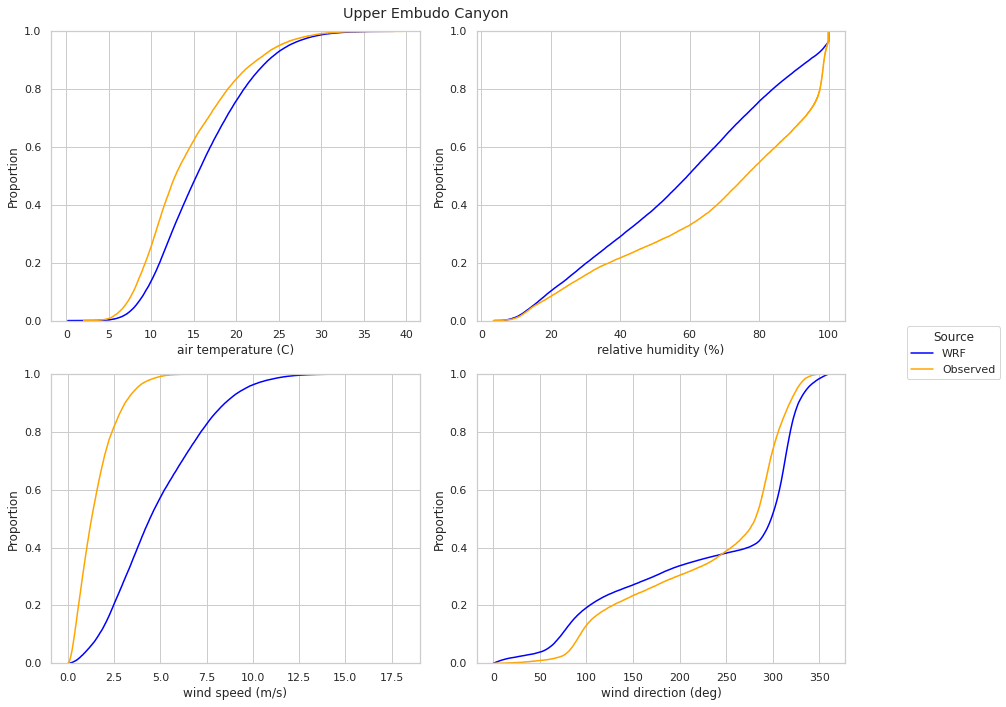

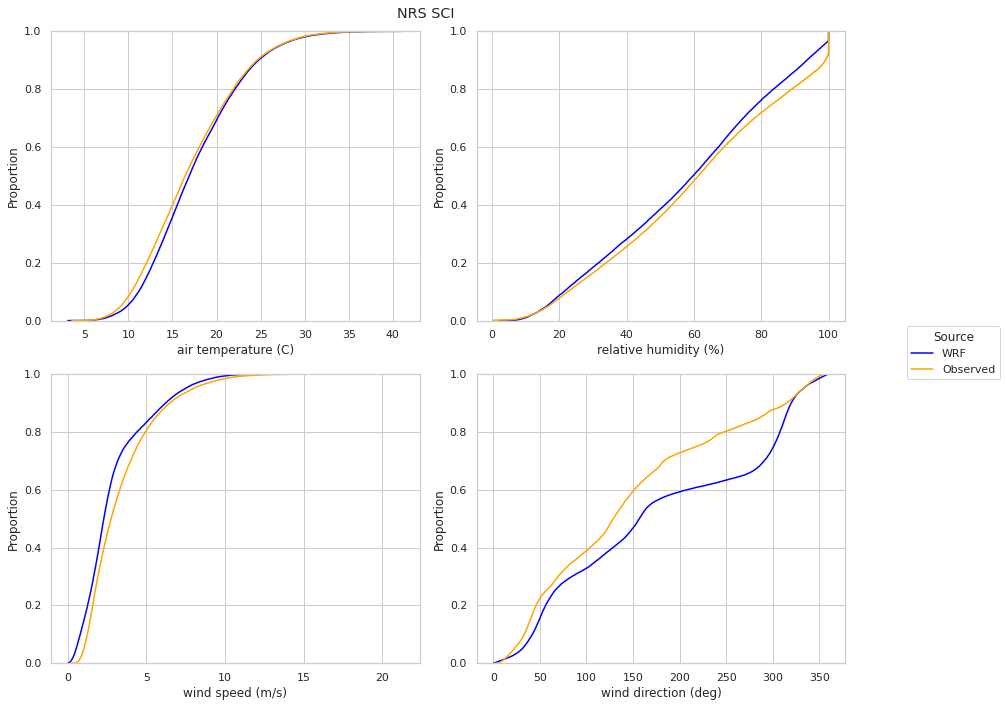

In [11]:
  for site in sites:
    plot_cdf(df, variables, site)


## Scatter Plots

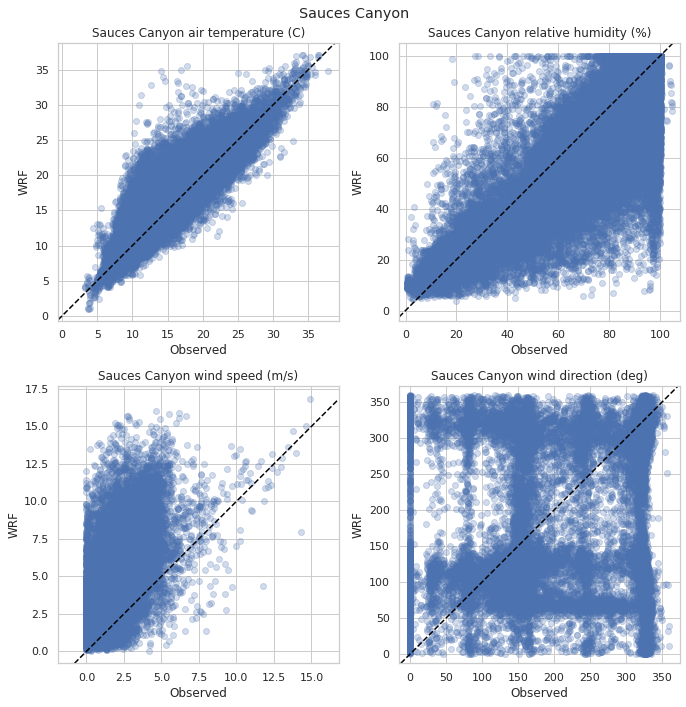

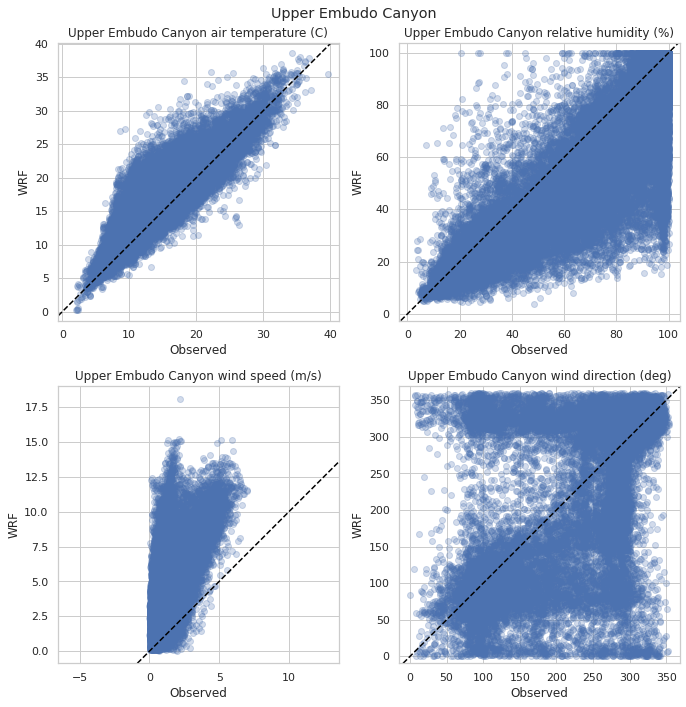

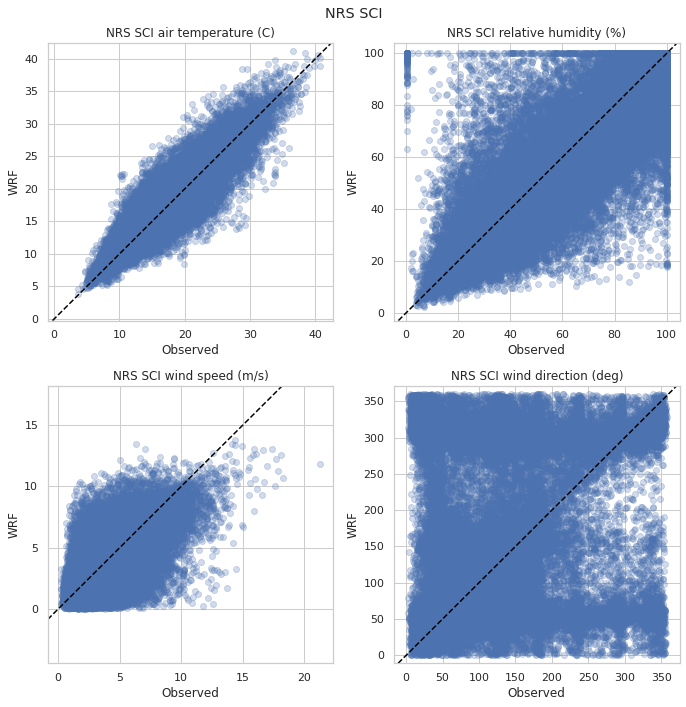

In [12]:
for site in sites:
    plot_scatter(df, variables, site)

## Time Series Plots

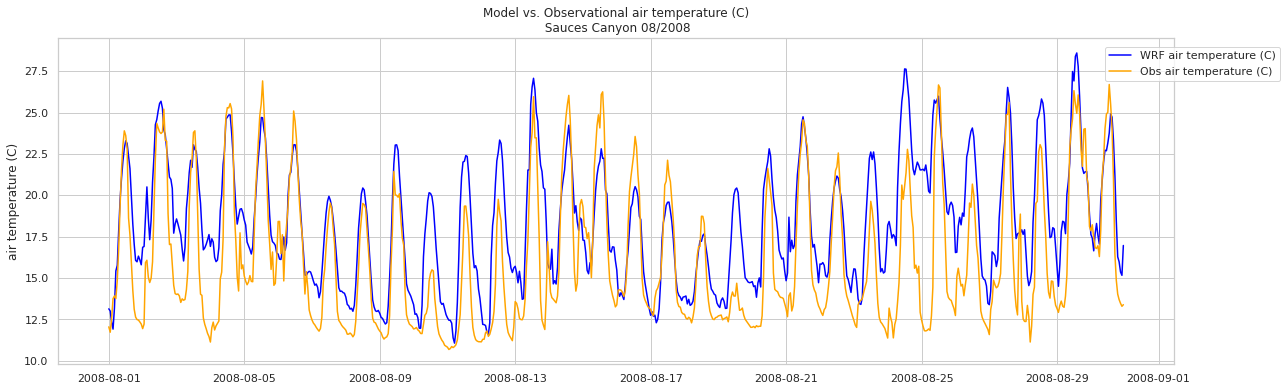

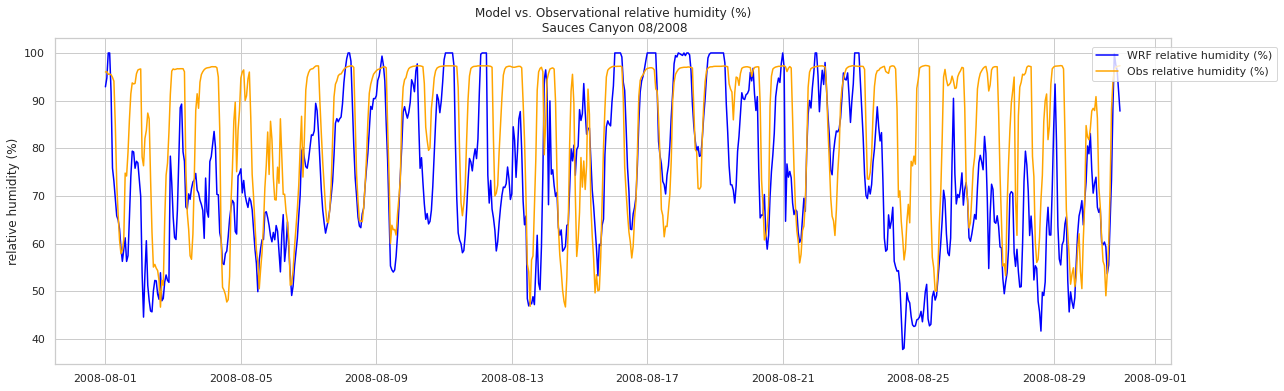

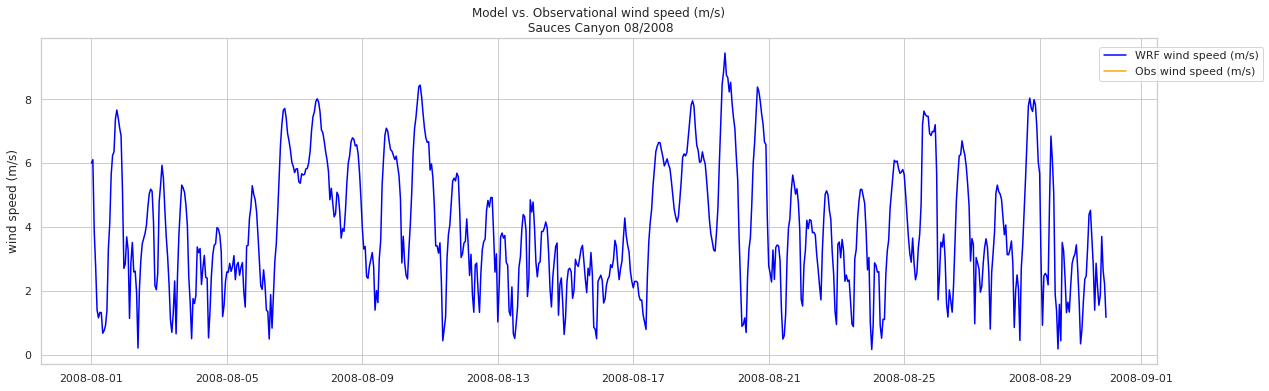

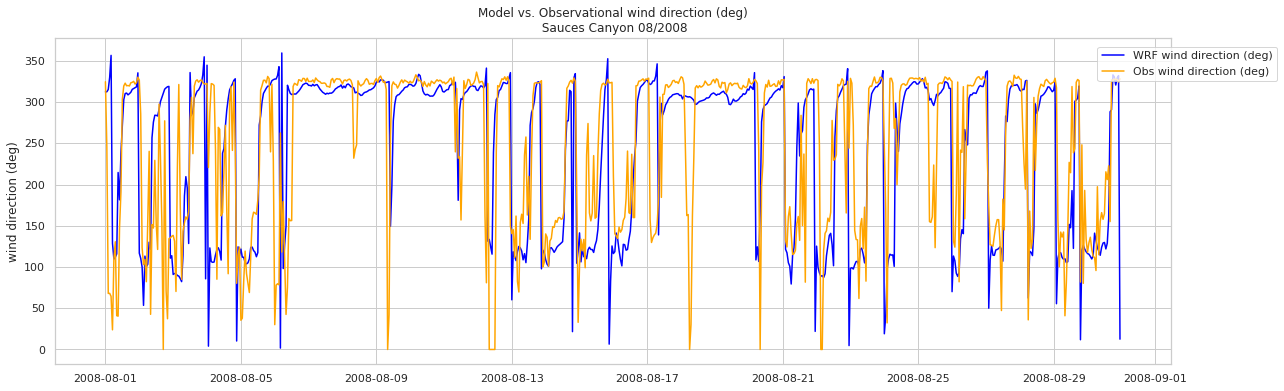

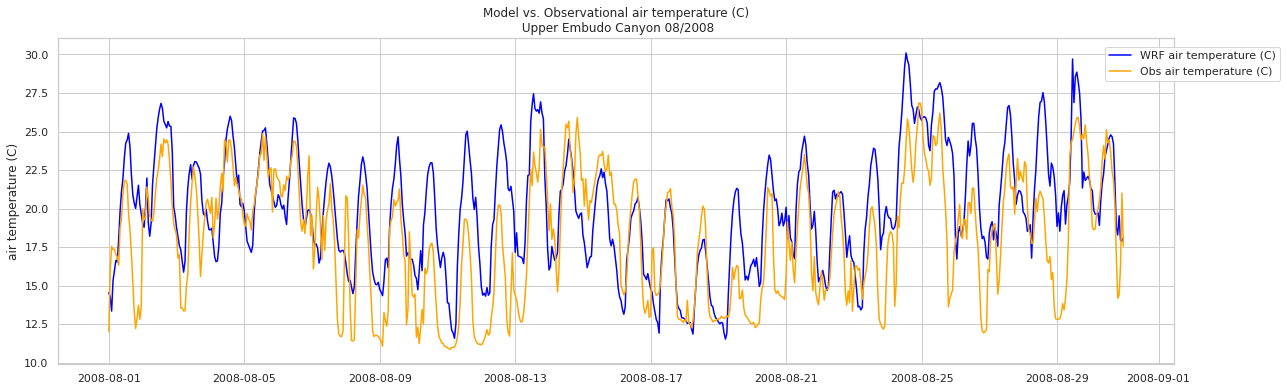

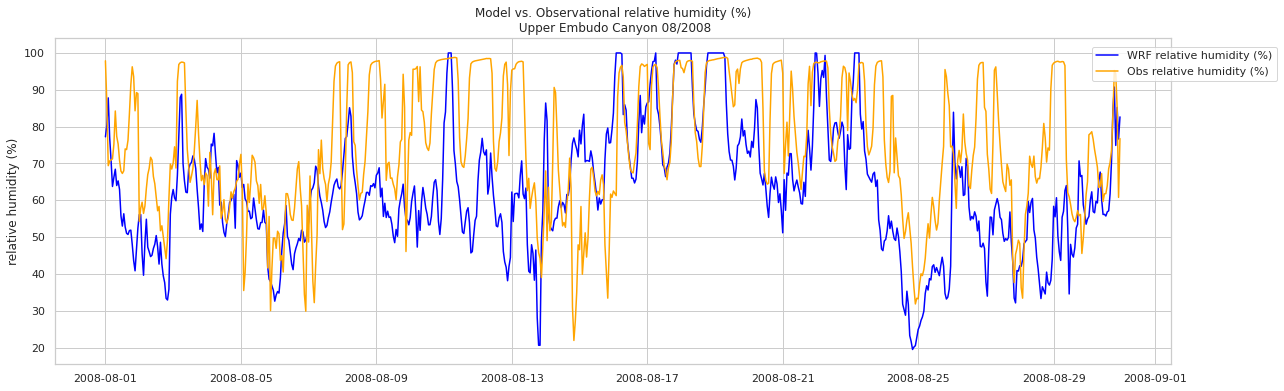

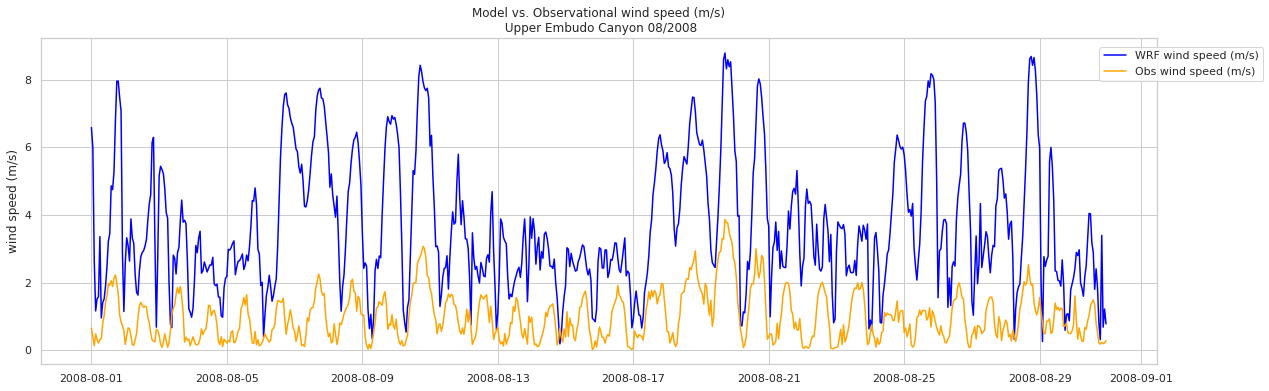

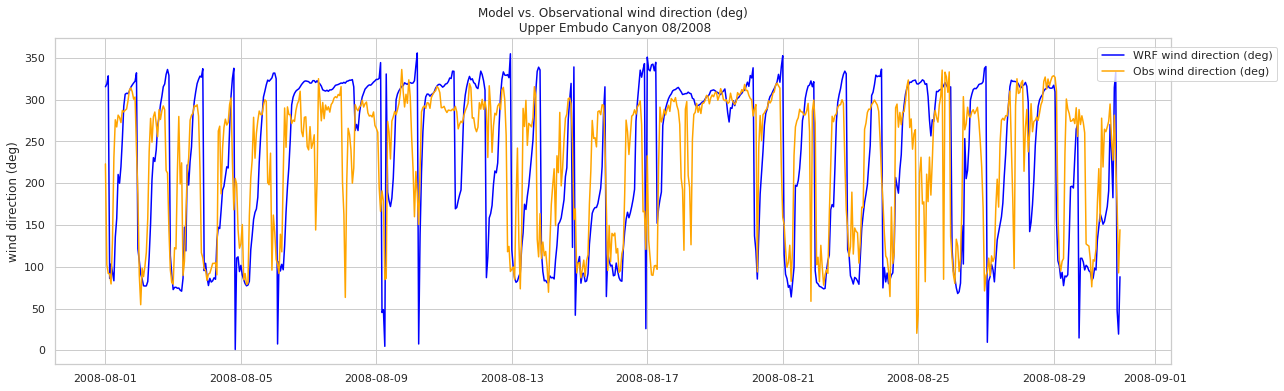

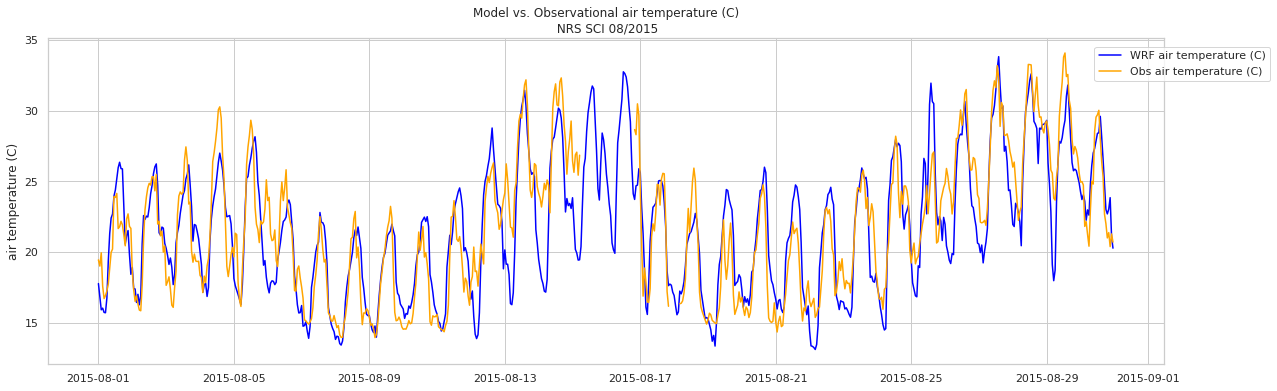

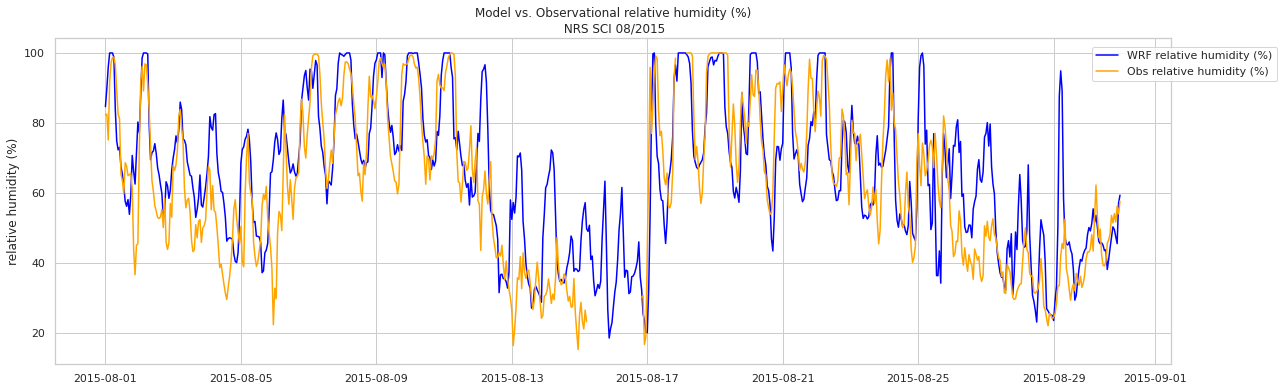

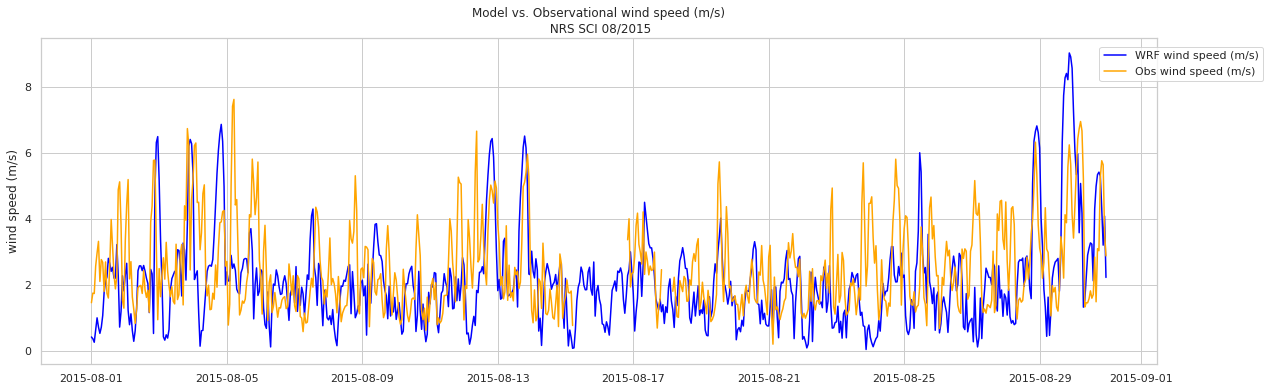

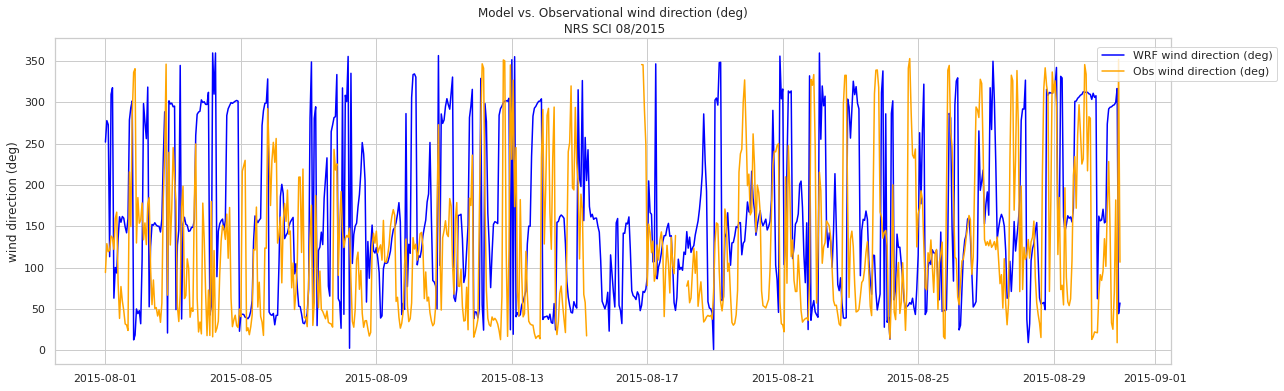

In [13]:
daterange = ['2008-08-01','2008-08-30']
nrs_daterange = ['2015-08-01', '2015-08-30']

for site in ['Sauces Canyon', 'Upper Embudo Canyon']:
    for var in variables:
        plot_timeseries(df, var, daterange, site)
        
for var in variables:
    plot_timeseries(df, var, nrs_daterange, 'NRS SCI')

# Fog Drip

In [63]:
# Define Sauces Fog
wsauc_fog = wsauc[['fog drip', 'relative humidity (%)','source']]
osauc_fog = osauc[['fog drip', 'relative humidity (%)', 'source']]

sauc_fog = pd.concat([wsauc_fog, osauc_fog], axis=0)
sauc_fog['binary fog'] = sauc_fog['fog drip'].apply(lambda x: 1 if x > 0 else 0)
sauc_fog.head()

# Define Upem Fog
wupem_fog = wupem[['fog drip', 'relative humidity (%)','source']]
oupem_fog = oupem[['fog drip', 'relative humidity (%)', 'source']]

upem_fog = pd.concat([wupem_fog, oupem_fog], axis=0)
upem_fog['binary fog'] = upem_fog['fog drip'].apply(lambda x: 1 if x > 0 else 0)
upem_fog.head()

,fog drip,relative humidity (%),source,binary fog
2002-06-30 16:00:00,0.0,86.297667,wrf,0
2002-06-30 17:00:00,0.0,72.221067,wrf,0
2002-06-30 18:00:00,0.0,69.414770,wrf,0
2002-06-30 19:00:00,0.0,77.571347,wrf,0
2002-06-30 20:00:00,0.0,76.824697,wrf,0


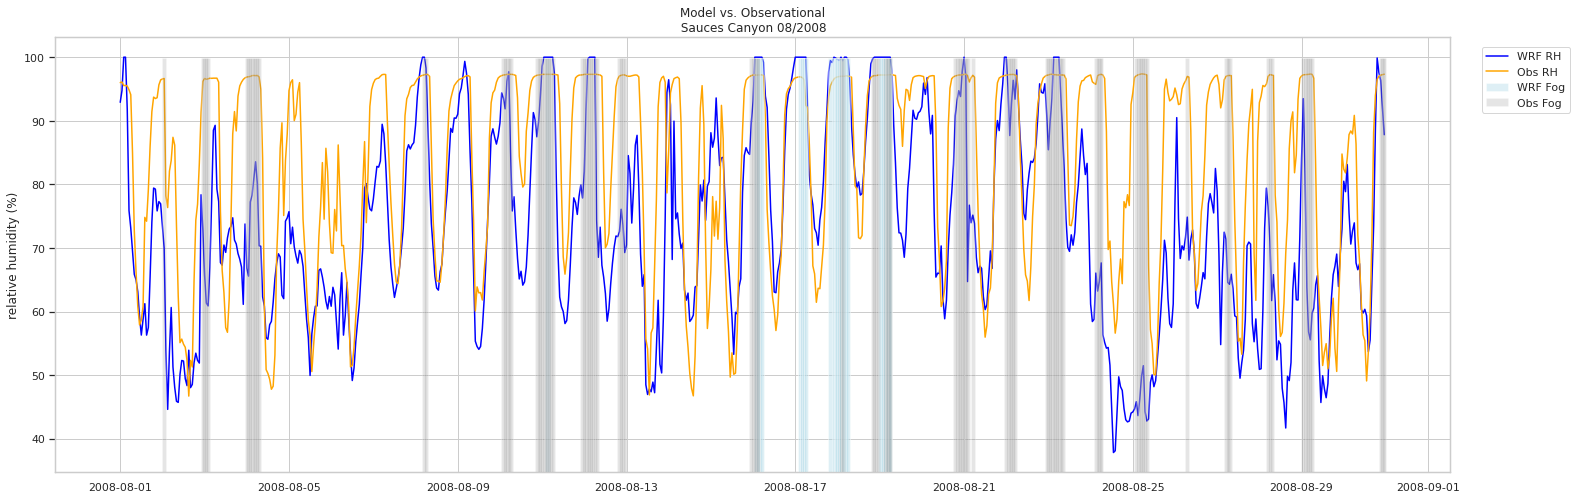

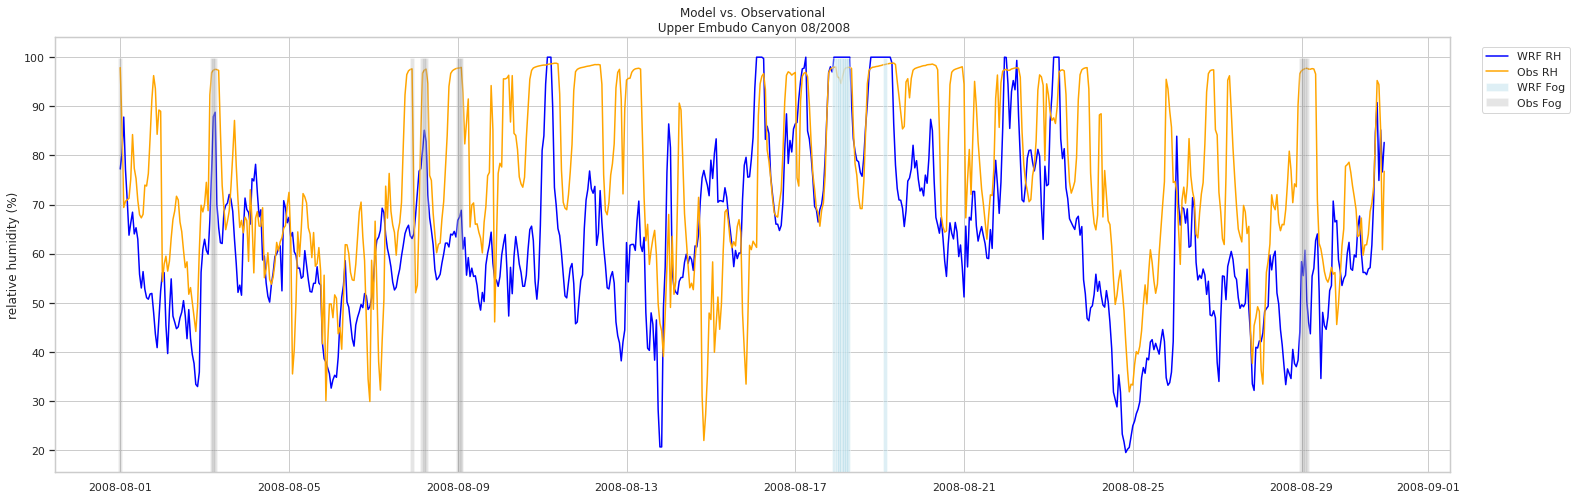

In [68]:
daterange = ['2008-08-01','2008-08-30']

def plot_fog(fog_df, daterange, site):
    wfog = fog_df.loc[fog_df['source'] == 'wrf']
    ofog = fog_df.loc[fog_df['source'] == 'obs']

    wfog = wfog[daterange[0] : daterange[1]]
    ofog = ofog[daterange[0] : daterange[1]]

    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(25, 8))
    ax2 = ax.twinx()
    ax.plot(wfog.index, wfog['relative humidity (%)'], color='blue', label='WRF RH')
    ax.plot(ofog.index, ofog['relative humidity (%)'], color='orange', label='Obs RH')

    ax2.bar(wfog.index, wfog['binary fog'], alpha=0.4, color='lightblue', width=0.1, label='WRF Fog')
    ax2.bar(ofog.index, ofog['binary fog'], alpha=0.2, color= 'gray', width=0.1, label='Obs Fog')
    ax2.get_yaxis().set_visible(False)

    ax.set(title=f'Model vs. Observational\n {site} {month}/{year}',
           ylabel=f'relative humidity (%)')

    fig.legend(loc='upper right', bbox_to_anchor=(1.09, .99), bbox_transform=ax.transAxes)
    plt.show()

plot_fog(sauc_fog, daterange, "Sauces Canyon")
plot_fog(upem_fog, daterange, "Upper Embudo Canyon")
